# 事前準備

In [163]:
import os
from tqdm import tqdm
import psutil
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn import preprocessing

import mca
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import optuna

from sklearn.ensemble import RandomForestClassifier as RFC
import lightgbm
from sklearn.svm import SVC

DATA_PATH = os.getcwd()+'/data/'
SUBMISSION_PATH = os.getcwd()+'/submission/'

In [3]:
# オリジナルの呼び出し
train_data = pd.read_csv(DATA_PATH+'train.csv', dtype=np.int16).drop('Id',axis=1)
test_data = pd.read_csv(DATA_PATH+'test.csv', dtype=np.int16).drop('Id',axis=1)

In [112]:
# ダウンサンプリング + PCA + SS を適用したデータの呼び出し
train_data = pd.read_csv(DATA_PATH+'train_pca_ss.csv', dtype=np.float32).drop('Unnamed: 0',axis=1)
test_data = pd.read_csv(DATA_PATH+'test_pca_ss.csv', dtype=np.float32).drop('Unnamed: 0',axis=1)

In [113]:
# メモリ容量を取得
mem = psutil.virtual_memory()
print(mem.total)
print(mem.available)

2082197504
745517056


# データの確認

In [6]:
train_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3189,40,8,30,13,3270,206,234,193,4873,...,0,0,0,0,0,0,0,0,0,1
1,3026,182,5,280,29,3270,233,240,106,5423,...,0,0,0,0,0,0,0,0,0,2
2,3106,13,7,351,37,2914,208,234,137,5269,...,0,0,0,0,0,0,0,0,0,1
3,3022,276,13,192,16,3034,207,238,156,2866,...,0,0,0,0,0,0,0,0,0,2
4,2906,186,13,266,22,2916,231,231,154,2642,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,2954,34,25,51,65,6314,240,237,103,1618,...,0,0,0,0,0,0,0,0,0,2
3999996,2926,104,8,696,83,5427,210,216,150,2863,...,0,0,0,0,0,0,0,0,0,2
3999997,2911,144,1,509,58,4820,195,192,91,92,...,0,0,0,0,0,0,0,1,0,2
3999998,2580,178,17,376,86,2592,225,183,39,1374,...,0,0,0,0,0,0,0,0,0,3


In [25]:
# 欠損値チェック
train_data.isnull().any()

Elevation                             False
Aspect                                False
Slope                                 False
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Wilderness_Area1                      False
Wilderness_Area2                      False
Wilderness_Area3                      False
Wilderness_Area4                      False
Soil_Type1                            False
Soil_Type2                            False
Soil_Type3                            False
Soil_Type4                            False
Soil_Type5                            False
Soil_Type6                            False
Soil_Type7                            False
Soil_Type8                            False
Soil_Type9                      

In [6]:
test_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2763,78,20,377,88,3104,218,213,195,1931,...,0,0,0,0,0,0,0,0,0,0
1,2826,153,11,264,39,295,219,238,148,2557,...,0,0,0,0,0,0,0,0,0,0
2,2948,57,19,56,44,852,202,217,163,1803,...,0,0,1,0,0,0,0,0,0,0
3,2926,119,6,158,134,2136,234,240,142,857,...,0,0,0,0,0,0,0,0,0,0
4,2690,10,4,38,108,3589,213,221,229,431,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2974,254,15,146,100,623,222,245,117,2353,...,0,0,0,0,0,0,0,0,0,0
999996,3180,92,16,93,47,3740,209,201,142,356,...,0,0,0,0,0,0,0,0,1,0
999997,2684,51,20,34,123,962,199,225,145,350,...,0,0,0,0,1,0,0,0,0,0
999998,3309,64,12,196,93,2522,226,193,74,3300,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# 欠損値チェック
test_data.isnull().any()

Elevation                             False
Aspect                                False
Slope                                 False
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Wilderness_Area1                      False
Wilderness_Area2                      False
Wilderness_Area3                      False
Wilderness_Area4                      False
Soil_Type1                            False
Soil_Type2                            False
Soil_Type3                            False
Soil_Type4                            False
Soil_Type5                            False
Soil_Type6                            False
Soil_Type7                            False
Soil_Type8                            False
Soil_Type9                      

(array([1.468136e+06, 2.262087e+06, 0.000000e+00, 1.957120e+05,
        0.000000e+00, 3.770000e+02, 1.000000e+00, 0.000000e+00,
        1.142600e+04, 6.226100e+04]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

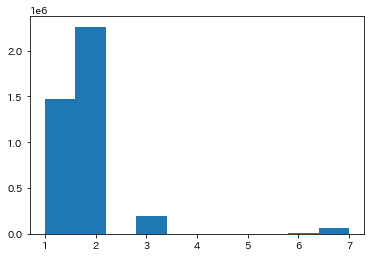

In [7]:
plt.hist(train_data['Cover_Type'])

In [5]:
print('------------- train data -------------')
for i in range(7):
    print("Cover_Type{}: {}".format(i+1, len(train_data[train_data['Cover_Type']==(i+1)])))

------------- train data -------------
Cover_Type1: 1468136
Cover_Type2: 2262087
Cover_Type3: 195712
Cover_Type4: 377
Cover_Type5: 1
Cover_Type6: 11426
Cover_Type7: 62261


# わかったこと

- 不均衡データによる多クラス分類  
  → 評価関数を工夫する  
  → マージン最大化を利用する  
  → ダウンサンプリング(Type4に合わせる)
- 説明変数の一部がスパース  
  → 多重対応分析による特徴量抽出  

# ベースライン

## 前処理

In [66]:
#説明変数
train_ex = train_data.drop('Cover_Type', axis=1)
#目的変数
train_ob = train_data['Cover_Type']

In [64]:
# 標準化
ss = preprocessing.StandardScaler()
train_ss = pd.DataFrame(ss.fit_transform(train_ex), index=train_ex.index, columns=train_ex.columns)

In [70]:
# 標準化
ss = preprocessing.StandardScaler()
test_ss = pd.DataFrame(ss.fit_transform(test_data), index=test_data.index, columns=test_data.columns)

In [65]:
train_ss

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.722400,-1.014774,-0.830439,-1.065177,-0.566768,1.142708,-0.189777,0.581997,1.194297,2.919073,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
1,0.158480,0.276592,-1.181450,0.038334,-0.332219,1.142708,0.687987,0.851886,-0.796612,3.406827,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
2,0.435250,-1.260315,-0.947443,0.351731,-0.214944,0.872111,-0.124758,0.581997,-0.087208,3.270256,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3,0.144641,1.131439,-0.245420,-0.350102,-0.522790,0.963324,-0.157268,0.761923,0.347588,1.139212,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
4,-0.256676,0.312968,-0.245420,-0.023463,-0.434834,0.873632,0.622968,0.447052,0.301820,0.940562,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,-0.090613,-1.069339,1.158626,-0.972482,0.195517,3.456465,0.915556,0.716941,-0.865264,0.032452,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3999996,-0.187483,-0.432750,-0.830439,1.874576,0.459385,2.782252,-0.059738,-0.227671,0.210284,1.136551,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3999997,-0.239378,-0.068985,-1.649466,1.049150,0.092902,2.320869,-0.547385,-1.307229,-1.139873,-1.320846,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,4.948200,-0.180696
3999998,-1.384516,0.240215,0.222595,0.462082,0.503363,0.627358,0.427909,-1.712063,-2.329841,-0.183934,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696


In [71]:
test_ss

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,-0.602909,-0.664981,0.600277,0.494061,0.532977,1.011325,0.202692,-0.386123,1.214559,0.219114,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
1,-0.419062,0.006883,-0.463930,-0.001615,-0.182141,-1.031701,0.234661,0.752728,0.179271,0.735520,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
2,-0.063040,-0.853103,0.482031,-0.914009,-0.109170,-0.626587,-0.308810,-0.203907,0.509682,0.113523,...,-0.174766,-0.213039,4.860751,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
3,-0.127241,-0.297695,-1.055157,-0.466585,1.204312,0.307285,0.714194,0.843836,0.047107,-0.666860,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
4,-0.815938,-1.274138,-1.291647,-0.992966,0.824862,1.364072,0.042848,-0.021691,1.963491,-1.018280,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.012833,0.911661,0.009050,-0.519223,0.708108,-0.793142,0.330568,1.071607,-0.503579,0.567235,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
999996,0.613984,-0.539567,0.127296,-0.751708,-0.065388,1.473897,-0.085028,-0.932772,0.047107,-1.080150,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,4.909152,-0.184089
999997,-0.833448,-0.906852,0.600277,-1.010512,1.043775,-0.546582,-0.404717,0.160525,0.113189,-1.085100,...,-0.174766,-0.213039,-0.205730,-0.110926,7.901116,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
999998,0.990433,-0.790396,-0.345685,-0.299898,0.605948,0.588028,0.458443,-1.297204,-1.450757,1.348443,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089


## モデル

In [68]:
lgbm = lightgbm.LGBMClassifier()

In [69]:
lgbm.fit(train_ss, train_ob)

LGBMClassifier()

In [73]:
y_pred = lgbm.predict(test_ss)

In [79]:
submission = pd.DataFrame([np.arange(4000000,5000000), y_pred], index=['Id','Cover_Type']).T

In [83]:
submission.to_csv(SUBMISSION_PATH+"baseline.csv", index=False)

評価値: 0.89983

# 実験

やることとして
1. ダウンサンプリング: trainデータをダウンサンプリング(Type:4に合わせる)
1. ~~多重対応分析: trainとtestを対象に，バイナリ変数に多重対応分析~~
    1. ~~一度にできないので，ランダムサンプリングし，最後に平均する~~
    1. ~~標準化: 全データに対して標準化を適用~~  
    1. ~~ここで，trainとtestを別途保存する~~
1. 主成分分析: あんま意味ないと思うけど，一応やっとく  
    1. 標準化: 全データに対して標準化を適用  
    1. ここで，trainとtestを別途保存する
1. アンサンブル学習: アンサンブル学習(LightGBM, SVMとか？)
    1. とりあえず，いろんなモデルを試してみよう！  
    1. アンサンブルに使うモデルを選定
    1. パラメータチューニング
1. testデータの適用

## ダウンサンプリング

In [46]:
# ランダムサンプリングでやります

train_ds = []
for i in range(7):
    cover_type = train_data[train_data['Cover_Type']==(i+1)]
    if (i+1) == 5:
        train_ds.append(cover_type)
        continue
    train_ds.append(cover_type.sample(n=377, random_state=0))
train_ds = pd.concat(train_ds).reset_index(drop=True)

In [47]:
train_ds

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3253,2,9,119,8,1977,246,212,132,6804,...,0,0,0,0,0,0,0,0,0,1
1,3211,86,13,353,22,1304,215,223,-6,2540,...,0,0,0,0,0,0,0,0,0,1
2,3261,160,13,1344,20,3340,226,242,141,2571,...,0,0,0,0,0,0,0,0,0,1
3,3485,23,23,179,100,3321,203,239,174,1983,...,0,0,0,0,0,0,0,0,0,1
4,3371,19,17,352,22,3995,167,220,114,2175,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,3583,42,15,63,80,3306,228,232,160,1137,...,0,0,0,0,0,0,1,0,0,7
2259,3333,64,4,446,9,993,224,211,183,104,...,0,0,0,1,0,0,0,0,0,7
2260,3503,350,27,266,88,1792,218,148,151,2011,...,1,0,0,0,0,0,0,0,0,7
2261,3323,92,9,336,200,-11,208,231,166,595,...,0,0,0,0,0,0,0,1,0,7


### データの成形

In [50]:
mca_targ = pd.concat([train_ds.iloc[:,10:-1],test_data.iloc[:,10:]])
mca_targ.index.name = "ID"
mca_targ

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
999997,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## 多重対応分析

### MCAの適用

In [59]:
stock = []
for i in tqdm(range(40000)):
    mca_counts = mca.MCA(train_data.sample(n=1000))
    rows = mca_counts.fs_r(N=5)  # 表側データ
    stock.append(rows)

100%|██████████| 40000/40000 [2:18:18<00:00,  4.82it/s]  


In [62]:
stock[0]

array([[ 0.06217426,  0.04923935],
       [-0.01771083,  0.06698257],
       [-0.01473002,  0.0959528 ],
       ...,
       [-0.05300595, -0.08317832],
       [ 0.04099149,  0.0451792 ],
       [-0.08582034,  0.01763725]])

In [63]:
mca_output = pd.concat(stock)
mca_output.index.name = "ID"
mca_output.sort_index(inplace=True)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [ ]:
mca_result = mca_output.groupby("ID").mean()

In [ ]:
# ここで結合もする

## 主成分分析

In [73]:
pca = PCA(n_components=21, random_state=0)
pca.fit(mca_targ)
print(sum(pca.explained_variance_ratio_))

0.8005384640472355


In [74]:
pca_result = pca.fit_transform(mca_targ)

In [80]:
pd.DataFrame(pca_result)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.535960,-0.147559,-0.116920,-0.084709,0.061977,-0.044211,-0.054743,-0.015430,-0.010363,-0.028805,...,-0.060893,-0.006174,-0.003734,-0.016724,-0.043711,-0.048997,-0.009520,-0.034362,-0.040869,-0.094170
1,-0.557427,0.712696,0.064416,-0.011341,-0.021344,-0.004720,-0.050285,-0.021411,0.002565,-0.046739,...,-0.101544,-0.008303,-0.008590,-0.025919,-0.051175,-0.046004,-0.017962,-0.041168,-0.039039,0.002208
2,-0.433909,-0.265061,-0.081437,-0.023352,-0.063405,-0.020485,-0.065878,-0.000487,0.001106,-0.063998,...,-0.132514,0.015870,0.002833,-0.036107,-0.068007,-0.043719,0.009635,-0.050336,-0.052866,-0.088597
3,-0.564240,0.705232,0.044111,-0.024428,-0.056395,-0.005848,-0.066237,-0.002848,0.015791,-0.076896,...,-0.205369,0.025651,-0.678698,0.557012,0.334577,0.114789,-0.096245,0.041929,0.005724,0.021760
4,0.535960,-0.147559,-0.116920,-0.084709,0.061977,-0.044211,-0.054743,-0.015430,-0.010363,-0.028805,...,-0.060893,-0.006174,-0.003734,-0.016724,-0.043711,-0.048997,-0.009520,-0.034362,-0.040869,-0.094170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002258,-0.437754,-0.265731,-0.082588,-0.023554,-0.062657,-0.010596,-0.059741,0.004311,0.005639,-0.067909,...,-0.122456,-0.001869,-0.003503,-0.034482,-0.064460,-0.030679,0.002238,-0.041013,-0.059266,-0.008264
1002259,-0.433174,-0.262970,-0.100267,0.011924,-0.113737,-0.026217,-0.042211,0.047198,0.051027,-0.071154,...,0.352348,-0.014995,0.002148,-0.020084,-0.077678,-0.047687,-0.008335,-0.030132,-0.030061,-0.015370
1002260,-0.554564,0.713738,0.065494,-0.010947,-0.024591,-0.022007,-0.049954,-0.015233,0.011239,-0.048539,...,-0.123175,-0.135016,0.058616,-0.535006,0.739882,0.118820,-0.044988,-0.033161,-0.013938,-0.081780
1002261,0.416785,0.830341,0.034928,-0.072380,0.100121,-0.034870,-0.044562,-0.037476,-0.010019,-0.009322,...,-0.039834,-0.008892,-0.015052,-0.009271,-0.035061,-0.063439,-0.032133,-0.028601,-0.039951,-0.074722


In [92]:
# 結合
org_items = pd.concat([train_ds.iloc[:,:10],test_data.iloc[:,:10]]).reset_index(drop=True)
pca_items = pd.DataFrame(pca_result)

pca_data = pd.concat([org_items, pca_items], axis=1)
pca_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,11,12,13,14,15,16,17,18,19,20
0,3253,2,9,119,8,1977,246,212,132,6804,...,-0.060893,-0.006174,-0.003734,-0.016724,-0.043711,-0.048997,-0.009520,-0.034362,-0.040869,-0.094170
1,3211,86,13,353,22,1304,215,223,-6,2540,...,-0.101544,-0.008303,-0.008590,-0.025919,-0.051175,-0.046004,-0.017962,-0.041168,-0.039039,0.002208
2,3261,160,13,1344,20,3340,226,242,141,2571,...,-0.132514,0.015870,0.002833,-0.036107,-0.068007,-0.043719,0.009635,-0.050336,-0.052866,-0.088597
3,3485,23,23,179,100,3321,203,239,174,1983,...,-0.205369,0.025651,-0.678698,0.557012,0.334577,0.114789,-0.096245,0.041929,0.005724,0.021760
4,3371,19,17,352,22,3995,167,220,114,2175,...,-0.060893,-0.006174,-0.003734,-0.016724,-0.043711,-0.048997,-0.009520,-0.034362,-0.040869,-0.094170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002258,2974,254,15,146,100,623,222,245,117,2353,...,-0.122456,-0.001869,-0.003503,-0.034482,-0.064460,-0.030679,0.002238,-0.041013,-0.059266,-0.008264
1002259,3180,92,16,93,47,3740,209,201,142,356,...,0.352348,-0.014995,0.002148,-0.020084,-0.077678,-0.047687,-0.008335,-0.030132,-0.030061,-0.015370
1002260,2684,51,20,34,123,962,199,225,145,350,...,-0.123175,-0.135016,0.058616,-0.535006,0.739882,0.118820,-0.044988,-0.033161,-0.013938,-0.081780
1002261,3309,64,12,196,93,2522,226,193,74,3300,...,-0.039834,-0.008892,-0.015052,-0.009271,-0.035061,-0.063439,-0.032133,-0.028601,-0.039951,-0.074722


### 標準化

In [98]:
ss = preprocessing.StandardScaler()
ss_pca_data = ss.fit_transform(pca_data.values)
ss_pca_data = pd.DataFrame(ss_pca_data, columns=pca_data.columns)

### 保存

In [124]:
train_pca_ss = ss_pca_data[:2263]
train_pca_ss = pd.concat([train_pca_ss,train_ds.iloc[:,-1]], axis=1 )
test_pca_ss = ss_pca_data[2263:]

In [127]:
# 保存 
train_pca_ss.to_csv('/home/workspace/Tabular_Playground_Series_Dec_2021/data/train_pca_ss.csv')
test_pca_ss.to_csv('/home/workspace/Tabular_Playground_Series_Dec_2021/data/test_pca_ss.csv')

## アンサンブル学習

### いろんなモデルを実装

Ramdom Forest，LightGBM，線形SVM，非線形SVM，MLP  
モデル + 交差検証 + パラメータチューニングの3本立て

In [114]:
train_data.where(train_data.loc[:,"Cover_Type"] == 5).dropna()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,12,13,14,15,16,17,18,19,20,Cover_Type
1508,-0.046914,-0.342419,2.846596,-0.733835,0.869071,-0.53254,-0.980379,-0.568295,0.972427,4.924982,...,-0.007639,-0.062936,-0.069738,-0.269311,-0.149618,0.013317,-0.101455,-0.180688,-0.466127,5.0


In [115]:
train_data_without_5 = train_data.drop(1508).reset_index(drop=True)

In [116]:
train_data_without_5.where(train_data_without_5.loc[:,"Cover_Type"] == 5).dropna()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,12,13,14,15,16,17,18,19,20,Cover_Type


#### Ramdom Forest

In [121]:
def objective(trial):
    X = train_data_without_5.iloc[:,:-1]
    y = train_data_without_5.iloc[:,-1]
    
    # ハイパーパラメータの決定
    n_estimators = trial.suggest_int("n_estimators", 100, 300, 2)
    criterion = trial.suggest_categorical("criterion", ("gini", "entropy"))
    max_depth = trial.suggest_int("max_depth", 31, 61, 2)
    
    train_acc, val_acc, test_acc = [], [], []
    
    # trainとtestに分ける
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=0, stratify=y)
    
    sss = StratifiedShuffleSplit(n_splits=5, train_size=0.8, random_state=0)
    for train_index, val_index in sss.split(train_X, train_y):
        model = RFC(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, random_state=0)
        model.fit(X.iloc[train_index], y[train_index])
        
        train_acc.append(model.score(X.iloc[train_index], y[train_index]))
        val_acc.append(model.score(X.iloc[val_index], y[val_index]))
        test_acc.append(model.score(test_X, test_y))

    print("train_acc: {}".format(np.mean(train_acc)))
    print("val_acc: {}".format(np.mean(val_acc)))
    print("test_acc: {}".format(np.mean(test_acc)))
    return np.mean(test_acc)

In [122]:
# パラメータチューニング
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"最良のハイパーパラメータ: {study.best_params}")

[I 2021-12-30 12:58:08,108] A new study created in memory with name: no-name-a8b773b5-eb39-499a-a43c-731cf64ffb27
[I 2021-12-30 12:58:11,859] Trial 0 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 130, 'criterion': 'entropy', 'max_depth': 45}. Best is trial 0 with value: 0.8154525386313466.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8154525386313466


[I 2021-12-30 12:58:19,903] Trial 1 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 272, 'criterion': 'entropy', 'max_depth': 39}. Best is trial 0 with value: 0.8154525386313466.


train_acc: 1.0
val_acc: 0.8839779005524863
test_acc: 0.8150110375275939


[I 2021-12-30 12:58:26,273] Trial 2 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 194, 'criterion': 'entropy', 'max_depth': 45}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8158940397350994


[I 2021-12-30 12:58:32,080] Trial 3 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 156, 'criterion': 'entropy', 'max_depth': 31}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8150110375275939


[I 2021-12-30 12:58:40,953] Trial 4 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 298, 'criterion': 'gini', 'max_depth': 59}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8158940397350992


[I 2021-12-30 12:58:48,976] Trial 5 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 194, 'criterion': 'entropy', 'max_depth': 47}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8158940397350994


[I 2021-12-30 12:58:52,580] Trial 6 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 114, 'criterion': 'gini', 'max_depth': 33}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8839779005524863
test_acc: 0.8150110375275939


[I 2021-12-30 12:58:57,660] Trial 7 finished with value: 0.814569536423841 and parameters: {'n_estimators': 116, 'criterion': 'entropy', 'max_depth': 49}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.814569536423841


[I 2021-12-30 12:59:06,890] Trial 8 finished with value: 0.8154525386313465 and parameters: {'n_estimators': 264, 'criterion': 'gini', 'max_depth': 31}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8154525386313465


[I 2021-12-30 12:59:16,761] Trial 9 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 230, 'criterion': 'entropy', 'max_depth': 57}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8154525386313466


[I 2021-12-30 12:59:24,431] Trial 10 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 184, 'criterion': 'entropy', 'max_depth': 41}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8806629834254143
test_acc: 0.8154525386313466


[I 2021-12-30 12:59:31,614] Trial 11 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 51}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8150110375275939


[I 2021-12-30 12:59:39,971] Trial 12 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 224, 'criterion': 'entropy', 'max_depth': 53}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8158940397350992


[I 2021-12-30 12:59:47,263] Trial 13 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 160, 'criterion': 'entropy', 'max_depth': 43}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8154525386313466


[I 2021-12-30 12:59:57,876] Trial 14 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 224, 'criterion': 'entropy', 'max_depth': 37}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8158940397350992


[I 2021-12-30 13:00:02,878] Trial 15 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 164, 'criterion': 'gini', 'max_depth': 47}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:00:09,458] Trial 16 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 194, 'criterion': 'entropy', 'max_depth': 53}. Best is trial 2 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8158940397350994


[I 2021-12-30 13:00:19,134] Trial 17 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 242, 'criterion': 'entropy', 'max_depth': 55}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8839779005524863
test_acc: 0.8163355408388521


[I 2021-12-30 13:00:26,813] Trial 18 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 246, 'criterion': 'gini', 'max_depth': 61}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8158940397350992


[I 2021-12-30 13:00:38,354] Trial 19 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 246, 'criterion': 'entropy', 'max_depth': 55}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8154525386313466


[I 2021-12-30 13:00:53,228] Trial 20 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 37}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8845303867403315
test_acc: 0.8154525386313466


[I 2021-12-30 13:01:01,291] Trial 21 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 180, 'criterion': 'entropy', 'max_depth': 47}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8806629834254144
test_acc: 0.8150110375275939


[I 2021-12-30 13:01:11,952] Trial 22 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 210, 'criterion': 'entropy', 'max_depth': 43}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8150110375275939


[I 2021-12-30 13:01:19,784] Trial 23 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 174, 'criterion': 'entropy', 'max_depth': 49}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8150110375275939


[I 2021-12-30 13:01:26,768] Trial 24 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 138, 'criterion': 'entropy', 'max_depth': 53}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8850828729281768
test_acc: 0.8158940397350992


[I 2021-12-30 13:01:34,558] Trial 25 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 208, 'criterion': 'entropy', 'max_depth': 57}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8150110375275939


[I 2021-12-30 13:01:43,881] Trial 26 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 240, 'criterion': 'gini', 'max_depth': 45}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8158940397350992


[I 2021-12-30 13:01:55,019] Trial 27 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 264, 'criterion': 'entropy', 'max_depth': 49}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8150110375275939


[I 2021-12-30 13:02:02,254] Trial 28 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 212, 'criterion': 'entropy', 'max_depth': 41}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8154525386313466


[I 2021-12-30 13:02:06,670] Trial 29 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 132, 'criterion': 'entropy', 'max_depth': 45}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8154525386313466


[I 2021-12-30 13:02:11,191] Trial 30 finished with value: 0.8150110375275939 and parameters: {'n_estimators': 146, 'criterion': 'entropy', 'max_depth': 51}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8150110375275939


[I 2021-12-30 13:02:15,363] Trial 31 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 164, 'criterion': 'gini', 'max_depth': 47}. Best is trial 17 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:02:20,030] Trial 32 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 55}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:02:24,177] Trial 33 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 168, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8158940397350994


[I 2021-12-30 13:02:28,551] Trial 34 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 182, 'criterion': 'gini', 'max_depth': 55}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8163355408388521


[I 2021-12-30 13:02:33,091] Trial 35 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 57}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:02:37,527] Trial 36 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 186, 'criterion': 'gini', 'max_depth': 57}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:02:41,198] Trial 37 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 59}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8154525386313466


[I 2021-12-30 13:02:47,962] Trial 38 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 286, 'criterion': 'gini', 'max_depth': 57}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8158940397350992


[I 2021-12-30 13:02:52,817] Trial 39 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 204, 'criterion': 'gini', 'max_depth': 59}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8167770419426048


[I 2021-12-30 13:02:55,228] Trial 40 finished with value: 0.814569536423841 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 59}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.814569536423841


[I 2021-12-30 13:02:59,672] Trial 41 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 190, 'criterion': 'gini', 'max_depth': 55}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8154525386313466


[I 2021-12-30 13:03:04,362] Trial 42 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 59}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:09,047] Trial 43 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:13,791] Trial 44 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:18,468] Trial 45 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:23,453] Trial 46 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 218, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:03:27,483] Trial 47 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 174, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8806629834254144
test_acc: 0.8158940397350994


[I 2021-12-30 13:03:32,793] Trial 48 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 230, 'criterion': 'gini', 'max_depth': 61}. Best is trial 32 with value: 0.8167770419426048.


train_acc: 1.0
val_acc: 0.8817679558011051
test_acc: 0.8158940397350992


[I 2021-12-30 13:03:37,268] Trial 49 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:03:41,800] Trial 50 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:46,271] Trial 51 finished with value: 0.8163355408388522 and parameters: {'n_estimators': 194, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8163355408388522


[I 2021-12-30 13:03:50,256] Trial 52 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 176, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:03:54,660] Trial 53 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:03:58,989] Trial 54 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:04:04,054] Trial 55 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 218, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:04:08,615] Trial 56 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:04:12,258] Trial 57 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 156, 'criterion': 'gini', 'max_depth': 53}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8806629834254144
test_acc: 0.8154525386313466


[I 2021-12-30 13:04:16,803] Trial 58 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:04:21,646] Trial 59 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 208, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:04:26,938] Trial 60 finished with value: 0.8154525386313465 and parameters: {'n_estimators': 234, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8154525386313465


[I 2021-12-30 13:04:31,256] Trial 61 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 192, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8154525386313466


[I 2021-12-30 13:04:35,766] Trial 62 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:04:40,717] Trial 63 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 218, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:04:45,190] Trial 64 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:04:49,294] Trial 65 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 178, 'criterion': 'gini', 'max_depth': 53}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:04:53,156] Trial 66 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 168, 'criterion': 'gini', 'max_depth': 51}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8158940397350994


[I 2021-12-30 13:05:02,530] Trial 67 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 202, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889501
test_acc: 0.8167770419426048


[I 2021-12-30 13:05:11,670] Trial 68 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 214, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350992


[I 2021-12-30 13:05:19,332] Trial 69 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:05:27,249] Trial 70 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 210, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8158940397350994


[I 2021-12-30 13:05:33,622] Trial 71 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 224, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:05:38,559] Trial 72 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 182, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8163355408388521


[I 2021-12-30 13:05:43,859] Trial 73 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:05:49,592] Trial 74 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 204, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8817679558011049
test_acc: 0.8167770419426048


[I 2021-12-30 13:05:55,205] Trial 75 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 188, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8167770419426048


[I 2021-12-30 13:06:00,460] Trial 76 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 51}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:06:05,930] Trial 77 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:06:10,759] Trial 78 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 172, 'criterion': 'gini', 'max_depth': 53}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:06:16,914] Trial 79 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 228, 'criterion': 'gini', 'max_depth': 33}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8817679558011051
test_acc: 0.8158940397350992


[I 2021-12-30 13:06:22,652] Trial 80 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 214, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350992


[I 2021-12-30 13:06:27,885] Trial 81 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:06:32,330] Trial 82 finished with value: 0.8163355408388522 and parameters: {'n_estimators': 184, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388522


[I 2021-12-30 13:06:36,484] Trial 83 finished with value: 0.8158940397350994 and parameters: {'n_estimators': 180, 'criterion': 'gini', 'max_depth': 55}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350994


[I 2021-12-30 13:06:41,317] Trial 84 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:06:46,189] Trial 85 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 208, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:06:51,421] Trial 86 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:06:59,116] Trial 87 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 222, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8163355408388521


[I 2021-12-30 13:07:08,160] Trial 88 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 206, 'criterion': 'gini', 'max_depth': 61}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8167770419426048


[I 2021-12-30 13:07:15,937] Trial 89 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:07:21,577] Trial 90 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:07:26,959] Trial 91 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 196, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048


[I 2021-12-30 13:07:32,901] Trial 92 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:07:38,219] Trial 93 finished with value: 0.8158940397350992 and parameters: {'n_estimators': 214, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8812154696132597
test_acc: 0.8158940397350992


[I 2021-12-30 13:07:43,232] Trial 94 finished with value: 0.8172185430463577 and parameters: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8834254143646408
test_acc: 0.8172185430463577


[I 2021-12-30 13:07:49,044] Trial 95 finished with value: 0.8163355408388521 and parameters: {'n_estimators': 208, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388521


[I 2021-12-30 13:07:53,716] Trial 96 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 192, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8154525386313466


[I 2021-12-30 13:07:59,530] Trial 97 finished with value: 0.8163355408388522 and parameters: {'n_estimators': 184, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8823204419889503
test_acc: 0.8163355408388522


[I 2021-12-30 13:08:06,206] Trial 98 finished with value: 0.8154525386313466 and parameters: {'n_estimators': 192, 'criterion': 'gini', 'max_depth': 57}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8801104972375692
test_acc: 0.8154525386313466


[I 2021-12-30 13:08:11,770] Trial 99 finished with value: 0.8167770419426048 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 59}. Best is trial 49 with value: 0.8172185430463577.


train_acc: 1.0
val_acc: 0.8828729281767955
test_acc: 0.8167770419426048
最良のハイパーパラメータ: {'n_estimators': 198, 'criterion': 'gini', 'max_depth': 59}


最良のハイパーパラメータ: {'n_estimators': 199, 'criterion': 'gini', 'max_depth': 39}  
train_acc: 1.0  
val_acc: 0.8828729281767955  
test_acc: 0.8172185430463577  

In [123]:
# 学習 + 予測値
rfc = RFC(n_estimators = 199, 
          criterion = 'gini', 
          max_depth= 39, 
          random_state=0)
rfc.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
y_pred = rfc.predict(test_data)

In [135]:
# 提出
submission = pd.DataFrame([np.arange(4000000,5000000), y_pred], index=['Id','Cover_Type']).T
submission['Id'] = submission['Id'].astype('int64')
submission['Cover_Type'] = submission['Cover_Type'].astype('int64')
submission.to_csv(SUBMISSION_PATH+"rfc.csv", index=False)

#### LightGBM

In [157]:
def objective(trial):
    X = train_data_without_5.iloc[:,:-1]
    y = train_data_without_5.iloc[:,-1]
    
    # ハイパーパラメータの決定
    n_estimators  = trial.suggest_int("n_estimators ", 1, 301, 3)
    max_depth = trial.suggest_int("max_depth", 1, 41, 2)
  
    train_acc, val_acc, test_acc = [], [], []
    
    # trainとtestに分ける
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=0, stratify=y)
    
    sss = StratifiedShuffleSplit(n_splits=5, train_size=0.8, random_state=0)
    for train_index, val_index in sss.split(train_X, train_y):
        model = lightgbm.LGBMClassifier(
            n_estimators=n_estimators, max_depth=max_depth, random_state=0)
        model.fit(X.iloc[train_index], y[train_index])
        
        train_acc.append(model.score(X.iloc[train_index], y[train_index]))
        val_acc.append(model.score(X.iloc[val_index], y[val_index]))
        test_acc.append(model.score(test_X, test_y))

    print("train_acc: {}".format(np.mean(train_acc)))
    print("val_acc: {}".format(np.mean(val_acc)))
    print("test_acc: {}".format(np.mean(test_acc)))
    return np.mean(test_acc)

In [158]:
# パラメータチューニング
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"最良のハイパーパラメータ: {study.best_params}")

[I 2021-12-30 16:14:54,066] A new study created in memory with name: no-name-e9ae91c9-6a33-4680-8888-6c876e632ab1
[I 2021-12-30 16:14:54,384] Trial 0 finished with value: 0.7324503311258279 and parameters: {'n_estimators ': 10, 'max_depth': 3}. Best is trial 0 with value: 0.7324503311258279.


train_acc: 0.9014512785072564
val_acc: 0.8646408839779005
test_acc: 0.7324503311258279


[I 2021-12-30 16:15:01,245] Trial 1 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 271, 'max_depth': 23}. Best is trial 1 with value: 0.8128035320088299.


train_acc: 1.0
val_acc: 0.9093922651933702
test_acc: 0.8128035320088299


[I 2021-12-30 16:15:06,772] Trial 2 finished with value: 0.8097130242825609 and parameters: {'n_estimators ': 178, 'max_depth': 11}. Best is trial 1 with value: 0.8128035320088299.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8097130242825609


[I 2021-12-30 16:15:08,762] Trial 3 finished with value: 0.8128035320088302 and parameters: {'n_estimators ': 91, 'max_depth': 5}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 1.0
val_acc: 0.9071823204419889
test_acc: 0.8128035320088302


[I 2021-12-30 16:15:15,690] Trial 4 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 226, 'max_depth': 39}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 1.0
val_acc: 0.9116022099447514
test_acc: 0.8128035320088299


[I 2021-12-30 16:15:20,303] Trial 5 finished with value: 0.8123620309050773 and parameters: {'n_estimators ': 88, 'max_depth': 39}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8123620309050773


[I 2021-12-30 16:15:26,549] Trial 6 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 196, 'max_depth': 25}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 1.0
val_acc: 0.9116022099447513
test_acc: 0.8128035320088299


[I 2021-12-30 16:15:28,132] Trial 7 finished with value: 0.8097130242825606 and parameters: {'n_estimators ': 34, 'max_depth': 17}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 1.0
val_acc: 0.8977900552486189
test_acc: 0.8097130242825606


[I 2021-12-30 16:15:31,986] Trial 8 finished with value: 0.8114790286975717 and parameters: {'n_estimators ': 91, 'max_depth': 31}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 1.0
val_acc: 0.9071823204419889
test_acc: 0.8114790286975717


[I 2021-12-30 16:15:38,189] Trial 9 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 217, 'max_depth': 33}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 1.0
val_acc: 0.9116022099447514
test_acc: 0.8128035320088299


[I 2021-12-30 16:15:38,762] Trial 10 finished with value: 0.7518763796909492 and parameters: {'n_estimators ': 115, 'max_depth': 1}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 0.9257774706288874
val_acc: 0.8845303867403315
test_acc: 0.7518763796909492


[I 2021-12-30 16:15:46,055] Trial 11 finished with value: 0.8114790286975717 and parameters: {'n_estimators ': 280, 'max_depth': 15}. Best is trial 3 with value: 0.8128035320088302.


train_acc: 1.0
val_acc: 0.9093922651933701
test_acc: 0.8114790286975717


[I 2021-12-30 16:15:56,135] Trial 12 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 301, 'max_depth': 23}. Best is trial 12 with value: 0.8132450331125828.


train_acc: 1.0
val_acc: 0.9099447513812156
test_acc: 0.8132450331125828


[I 2021-12-30 16:16:06,533] Trial 13 finished with value: 0.8136865342163355 and parameters: {'n_estimators ': 136, 'max_depth': 9}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9093922651933701
test_acc: 0.8136865342163355


[I 2021-12-30 16:16:13,800] Trial 14 finished with value: 0.8097130242825609 and parameters: {'n_estimators ': 148, 'max_depth': 11}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9044198895027623
test_acc: 0.8097130242825609


[I 2021-12-30 16:16:21,914] Trial 15 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 301, 'max_depth': 27}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9099447513812156
test_acc: 0.8132450331125828


[I 2021-12-30 16:16:29,801] Trial 16 finished with value: 0.8123620309050772 and parameters: {'n_estimators ': 151, 'max_depth': 19}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.911049723756906
test_acc: 0.8123620309050772


[I 2021-12-30 16:16:39,757] Trial 17 finished with value: 0.8119205298013246 and parameters: {'n_estimators ': 247, 'max_depth': 9}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9099447513812156
test_acc: 0.8119205298013246


[I 2021-12-30 16:16:43,082] Trial 18 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 61, 'max_depth': 29}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9049723756906077
test_acc: 0.8132450331125828


[I 2021-12-30 16:16:45,845] Trial 19 finished with value: 0.8123620309050773 and parameters: {'n_estimators ': 49, 'max_depth': 31}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.905524861878453
test_acc: 0.8123620309050773


[I 2021-12-30 16:16:52,985] Trial 20 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 133, 'max_depth': 27}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9116022099447514
test_acc: 0.8132450331125828


[I 2021-12-30 16:16:59,709] Trial 21 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 130, 'max_depth': 27}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9099447513812156
test_acc: 0.8132450331125828


[I 2021-12-30 16:17:07,365] Trial 22 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 178, 'max_depth': 21}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9121546961325967
test_acc: 0.8128035320088299


[I 2021-12-30 16:17:11,283] Trial 23 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 61, 'max_depth': 33}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9049723756906077
test_acc: 0.8132450331125828


[I 2021-12-30 16:17:21,510] Trial 24 finished with value: 0.8110375275938191 and parameters: {'n_estimators ': 103, 'max_depth': 33}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9049723756906076
test_acc: 0.8110375275938191


[I 2021-12-30 16:17:31,888] Trial 25 finished with value: 0.8114790286975717 and parameters: {'n_estimators ': 256, 'max_depth': 15}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9093922651933701
test_acc: 0.8114790286975717


[I 2021-12-30 16:17:36,224] Trial 26 finished with value: 0.8128035320088302 and parameters: {'n_estimators ': 67, 'max_depth': 21}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.905524861878453
test_acc: 0.8128035320088302


[I 2021-12-30 16:17:36,870] Trial 27 finished with value: 0.7549668874172186 and parameters: {'n_estimators ': 7, 'max_depth': 41}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 0.9375259156876297
val_acc: 0.8740331491712707
test_acc: 0.7549668874172186


[I 2021-12-30 16:17:45,246] Trial 28 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 136, 'max_depth': 27}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9104972375690608
test_acc: 0.8128035320088299


[I 2021-12-30 16:17:51,468] Trial 29 finished with value: 0.8123620309050773 and parameters: {'n_estimators ': 169, 'max_depth': 5}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9033149171270718
test_acc: 0.8123620309050773


[I 2021-12-30 16:17:53,798] Trial 30 finished with value: 0.8088300220750553 and parameters: {'n_estimators ': 28, 'max_depth': 35}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 0.9987560469937803
val_acc: 0.8917127071823204
test_acc: 0.8088300220750553


[I 2021-12-30 16:18:00,165] Trial 31 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 130, 'max_depth': 35}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9099447513812156
test_acc: 0.8132450331125828


[I 2021-12-30 16:18:13,677] Trial 32 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 202, 'max_depth': 25}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9116022099447514
test_acc: 0.8128035320088299


[I 2021-12-30 16:18:20,965] Trial 33 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 121, 'max_depth': 37}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.911049723756906
test_acc: 0.8132450331125828


[I 2021-12-30 16:18:26,931] Trial 34 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 115, 'max_depth': 37}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9099447513812156
test_acc: 0.8128035320088299


[I 2021-12-30 16:18:31,698] Trial 35 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 79, 'max_depth': 29}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9071823204419889
test_acc: 0.8132450331125828


[I 2021-12-30 16:18:40,081] Trial 36 finished with value: 0.8123620309050773 and parameters: {'n_estimators ': 154, 'max_depth': 29}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9127071823204419
test_acc: 0.8123620309050773


[I 2021-12-30 16:18:44,245] Trial 37 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 61, 'max_depth': 31}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9049723756906077
test_acc: 0.8132450331125828


[I 2021-12-30 16:18:49,027] Trial 38 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 79, 'max_depth': 41}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9071823204419889
test_acc: 0.8132450331125828


[I 2021-12-30 16:18:56,457] Trial 39 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 169, 'max_depth': 9}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9099447513812156
test_acc: 0.8132450331125828


[I 2021-12-30 16:19:04,505] Trial 40 finished with value: 0.8128035320088302 and parameters: {'n_estimators ': 178, 'max_depth': 9}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9099447513812156
test_acc: 0.8128035320088302


[I 2021-12-30 16:19:09,011] Trial 41 finished with value: 0.8123620309050773 and parameters: {'n_estimators ': 88, 'max_depth': 23}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8123620309050773


[I 2021-12-30 16:19:10,619] Trial 42 finished with value: 0.8088300220750553 and parameters: {'n_estimators ': 25, 'max_depth': 27}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 0.9968210089841051
val_acc: 0.8961325966850829
test_acc: 0.8088300220750553


[I 2021-12-30 16:19:17,934] Trial 43 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 124, 'max_depth': 37}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9121546961325967
test_acc: 0.8132450331125828


[I 2021-12-30 16:19:21,317] Trial 44 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 106, 'max_depth': 5}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9077348066298342
test_acc: 0.8128035320088299


[I 2021-12-30 16:19:24,012] Trial 45 finished with value: 0.8119205298013246 and parameters: {'n_estimators ': 52, 'max_depth': 35}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.905524861878453
test_acc: 0.8119205298013246


[I 2021-12-30 16:19:28,035] Trial 46 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 73, 'max_depth': 33}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9071823204419889
test_acc: 0.8128035320088299


[I 2021-12-30 16:19:30,696] Trial 47 finished with value: 0.8123620309050773 and parameters: {'n_estimators ': 43, 'max_depth': 29}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9038674033149171
test_acc: 0.8123620309050773


[I 2021-12-30 16:19:36,825] Trial 48 finished with value: 0.8123620309050772 and parameters: {'n_estimators ': 142, 'max_depth': 25}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9104972375690608
test_acc: 0.8123620309050772


[I 2021-12-30 16:19:43,539] Trial 49 finished with value: 0.8136865342163355 and parameters: {'n_estimators ': 163, 'max_depth': 9}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9104972375690608
test_acc: 0.8136865342163355


[I 2021-12-30 16:19:48,016] Trial 50 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 79, 'max_depth': 15}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9049723756906077
test_acc: 0.8132450331125828


[I 2021-12-30 16:19:54,848] Trial 51 finished with value: 0.8123620309050773 and parameters: {'n_estimators ': 100, 'max_depth': 13}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9060773480662982
test_acc: 0.8123620309050773


[I 2021-12-30 16:20:06,332] Trial 52 finished with value: 0.8114790286975717 and parameters: {'n_estimators ': 226, 'max_depth': 7}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.9093922651933702
test_acc: 0.8114790286975717


[I 2021-12-30 16:20:12,639] Trial 53 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 163, 'max_depth': 19}. Best is trial 13 with value: 0.8136865342163355.


train_acc: 1.0
val_acc: 0.911049723756906
test_acc: 0.8128035320088299


[I 2021-12-30 16:20:14,967] Trial 54 finished with value: 0.8158940397350992 and parameters: {'n_estimators ': 133, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 0.9998617829993088
val_acc: 0.9077348066298342
test_acc: 0.8158940397350992


[I 2021-12-30 16:20:16,030] Trial 55 finished with value: 0.7629139072847682 and parameters: {'n_estimators ': 151, 'max_depth': 1}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 0.938217000691085
val_acc: 0.8933701657458564
test_acc: 0.7629139072847682


[I 2021-12-30 16:20:19,750] Trial 56 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 280, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9033149171270718
test_acc: 0.8132450331125828


[I 2021-12-30 16:20:21,966] Trial 57 finished with value: 0.8154525386313466 and parameters: {'n_estimators ': 187, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8154525386313466


[I 2021-12-30 16:20:28,843] Trial 58 finished with value: 0.8097130242825606 and parameters: {'n_estimators ': 196, 'max_depth': 11}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9077348066298343
test_acc: 0.8097130242825606


[I 2021-12-30 16:20:31,608] Trial 59 finished with value: 0.8154525386313466 and parameters: {'n_estimators ': 187, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8154525386313466


[I 2021-12-30 16:20:34,277] Trial 60 finished with value: 0.8150110375275939 and parameters: {'n_estimators ': 205, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8150110375275939


[I 2021-12-30 16:20:36,961] Trial 61 finished with value: 0.8150110375275939 and parameters: {'n_estimators ': 199, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.905524861878453
test_acc: 0.8150110375275939


[I 2021-12-30 16:20:40,167] Trial 62 finished with value: 0.8150110375275939 and parameters: {'n_estimators ': 205, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8150110375275939


[I 2021-12-30 16:20:41,218] Trial 63 finished with value: 0.7704194260485652 and parameters: {'n_estimators ': 205, 'max_depth': 1}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 0.9501036627505183
val_acc: 0.8994475138121547
test_acc: 0.7704194260485652


[I 2021-12-30 16:20:44,018] Trial 64 finished with value: 0.8136865342163355 and parameters: {'n_estimators ': 229, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.905524861878453
test_acc: 0.8136865342163355


[I 2021-12-30 16:20:52,415] Trial 65 finished with value: 0.8119205298013246 and parameters: {'n_estimators ': 187, 'max_depth': 7}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9088397790055248
test_acc: 0.8119205298013246


[I 2021-12-30 16:20:54,816] Trial 66 finished with value: 0.8141280353200884 and parameters: {'n_estimators ': 214, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9060773480662985
test_acc: 0.8141280353200884


[I 2021-12-30 16:20:57,222] Trial 67 finished with value: 0.8141280353200884 and parameters: {'n_estimators ': 214, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9060773480662985
test_acc: 0.8141280353200884


[I 2021-12-30 16:21:03,901] Trial 68 finished with value: 0.8119205298013246 and parameters: {'n_estimators ': 241, 'max_depth': 7}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9104972375690608
test_acc: 0.8119205298013246


[I 2021-12-30 16:21:05,037] Trial 69 finished with value: 0.7695364238410597 and parameters: {'n_estimators ': 187, 'max_depth': 1}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 0.9462335867311678
val_acc: 0.8977900552486189
test_acc: 0.7695364238410597


[I 2021-12-30 16:21:10,412] Trial 70 finished with value: 0.8114790286975717 and parameters: {'n_estimators ': 214, 'max_depth': 5}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9038674033149171
test_acc: 0.8114790286975717


[I 2021-12-30 16:21:12,852] Trial 71 finished with value: 0.8150110375275939 and parameters: {'n_estimators ': 211, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9060773480662985
test_acc: 0.8150110375275939


[I 2021-12-30 16:21:15,006] Trial 72 finished with value: 0.8150110375275939 and parameters: {'n_estimators ': 190, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9049723756906077
test_acc: 0.8150110375275939


[I 2021-12-30 16:21:22,363] Trial 73 finished with value: 0.8123620309050772 and parameters: {'n_estimators ': 196, 'max_depth': 5}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9038674033149171
test_acc: 0.8123620309050772


[I 2021-12-30 16:21:24,790] Trial 74 finished with value: 0.8154525386313466 and parameters: {'n_estimators ': 187, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8154525386313466


[I 2021-12-30 16:21:26,021] Trial 75 finished with value: 0.7721854304635762 and parameters: {'n_estimators ': 223, 'max_depth': 1}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 0.953144436765722
val_acc: 0.9033149171270718
test_acc: 0.7721854304635762


[I 2021-12-30 16:21:32,550] Trial 76 finished with value: 0.8114790286975717 and parameters: {'n_estimators ': 184, 'max_depth': 5}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9033149171270718
test_acc: 0.8114790286975717


[I 2021-12-30 16:21:41,153] Trial 77 finished with value: 0.8123620309050773 and parameters: {'n_estimators ': 175, 'max_depth': 7}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9082872928176796
test_acc: 0.8123620309050773


[I 2021-12-30 16:21:44,739] Trial 78 finished with value: 0.8136865342163355 and parameters: {'n_estimators ': 241, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9033149171270718
test_acc: 0.8136865342163355


[I 2021-12-30 16:21:45,764] Trial 79 finished with value: 0.7690949227373068 and parameters: {'n_estimators ': 193, 'max_depth': 1}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 0.9474775397373877
val_acc: 0.9005524861878452
test_acc: 0.7690949227373068


[I 2021-12-30 16:21:52,411] Trial 80 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 256, 'max_depth': 5}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9060773480662982
test_acc: 0.8128035320088299


[I 2021-12-30 16:21:54,864] Trial 81 finished with value: 0.8145695364238412 and parameters: {'n_estimators ': 208, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8145695364238412


[I 2021-12-30 16:21:57,210] Trial 82 finished with value: 0.814569536423841 and parameters: {'n_estimators ': 202, 'max_depth': 3}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9060773480662982
test_acc: 0.814569536423841


[I 2021-12-30 16:22:01,670] Trial 83 finished with value: 0.8114790286975717 and parameters: {'n_estimators ': 184, 'max_depth': 5}. Best is trial 54 with value: 0.8158940397350992.


train_acc: 1.0
val_acc: 0.9033149171270718
test_acc: 0.8114790286975717


[I 2021-12-30 16:22:03,566] Trial 84 finished with value: 0.8158940397350994 and parameters: {'n_estimators ': 160, 'max_depth': 3}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.9044198895027623
test_acc: 0.8158940397350994


[I 2021-12-30 16:22:11,252] Trial 85 finished with value: 0.8119205298013246 and parameters: {'n_estimators ': 169, 'max_depth': 7}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.9077348066298342
test_acc: 0.8119205298013246


[I 2021-12-30 16:22:12,196] Trial 86 finished with value: 0.7664459161147903 and parameters: {'n_estimators ': 160, 'max_depth': 1}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 0.9409813407049068
val_acc: 0.8950276243093922
test_acc: 0.7664459161147903


[I 2021-12-30 16:22:13,359] Trial 87 finished with value: 0.7682119205298015 and parameters: {'n_estimators ': 175, 'max_depth': 1}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 0.944713199723566
val_acc: 0.8972375690607735
test_acc: 0.7682119205298015


[I 2021-12-30 16:22:18,819] Trial 88 finished with value: 0.8119205298013246 and parameters: {'n_estimators ': 190, 'max_depth': 5}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.9044198895027625
test_acc: 0.8119205298013246


[I 2021-12-30 16:22:21,768] Trial 89 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 235, 'max_depth': 3}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.905524861878453
test_acc: 0.8132450331125828


[I 2021-12-30 16:22:30,391] Trial 90 finished with value: 0.8128035320088299 and parameters: {'n_estimators ': 202, 'max_depth': 7}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.9093922651933701
test_acc: 0.8128035320088299


[I 2021-12-30 16:22:32,975] Trial 91 finished with value: 0.8158940397350994 and parameters: {'n_estimators ': 142, 'max_depth': 3}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.9049723756906077
test_acc: 0.8158940397350994


[I 2021-12-30 16:22:33,935] Trial 92 finished with value: 0.7598233995584989 and parameters: {'n_estimators ': 139, 'max_depth': 1}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 0.9340704906703525
val_acc: 0.8911602209944751
test_acc: 0.7598233995584989


[I 2021-12-30 16:22:39,368] Trial 93 finished with value: 0.8119205298013246 and parameters: {'n_estimators ': 157, 'max_depth': 5}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.9049723756906077
test_acc: 0.8119205298013246


[I 2021-12-30 16:22:42,034] Trial 94 finished with value: 0.8154525386313466 and parameters: {'n_estimators ': 145, 'max_depth': 3}. Best is trial 84 with value: 0.8158940397350994.


train_acc: 1.0
val_acc: 0.905524861878453
test_acc: 0.8154525386313466


[I 2021-12-30 16:22:44,733] Trial 95 finished with value: 0.8163355408388521 and parameters: {'n_estimators ': 127, 'max_depth': 3}. Best is trial 95 with value: 0.8163355408388521.


train_acc: 0.9995853489979268
val_acc: 0.9082872928176796
test_acc: 0.8163355408388521


[I 2021-12-30 16:22:49,689] Trial 96 finished with value: 0.8128035320088302 and parameters: {'n_estimators ': 121, 'max_depth': 5}. Best is trial 95 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.9077348066298342
test_acc: 0.8128035320088302


[I 2021-12-30 16:22:50,393] Trial 97 finished with value: 0.7642384105960265 and parameters: {'n_estimators ': 148, 'max_depth': 1}. Best is trial 95 with value: 0.8163355408388521.


train_acc: 0.9373876986869385
val_acc: 0.8917127071823204
test_acc: 0.7642384105960265


[I 2021-12-30 16:22:57,519] Trial 98 finished with value: 0.8110375275938189 and parameters: {'n_estimators ': 145, 'max_depth': 7}. Best is trial 95 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.9066298342541437
test_acc: 0.8110375275938189


[I 2021-12-30 16:23:05,863] Trial 99 finished with value: 0.8132450331125828 and parameters: {'n_estimators ': 130, 'max_depth': 9}. Best is trial 95 with value: 0.8163355408388521.


train_acc: 1.0
val_acc: 0.9082872928176796
test_acc: 0.8132450331125828
最良のハイパーパラメータ: {'n_estimators ': 127, 'max_depth': 3}


{'n_estimators ': 160, 'max_depth': 3}  
train_acc: 1.0  
val_acc: 0.9044198895027623  
test_acc: 0.8158940397350994  

In [189]:
# 学習 + 予測値
lightgbm = lightgbm.LGBMClassifier(n_estimators = 160, 
                                   max_depth= 3,
                                   random_state=0)
lightgbm.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
y_pred = lightgbm.predict(test_data)

In [190]:
# 提出
submission = pd.DataFrame([np.arange(4000000,5000000), y_pred], index=['Id','Cover_Type']).T
submission['Id'] = submission['Id'].astype('int64')
submission['Cover_Type'] = submission['Cover_Type'].astype('int64')
submission.to_csv(SUBMISSION_PATH+"lightgbm.csv", index=False)

#### 非線形SVM

In [184]:
def objective(trial):
    X = train_data_without_5.iloc[:,:-1]
    y = train_data_without_5.iloc[:,-1]
    
    # ハイパーパラメータの決定
    kernel = trial.suggest_categorical("kernel", ("poly","rbf"))
    C = trial.suggest_float("C", 400, 700)
    gamma = trial.suggest_float("gamma", 0.01, 0.04)
    
    train_acc, val_acc, test_acc = [], [], []
    
    # trainとtestに分ける
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=0, stratify=y)
    
    sss = StratifiedShuffleSplit(n_splits=5, train_size=0.8, random_state=0)
    for train_index, val_index in sss.split(train_X, train_y):
        model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=0)
        model.fit(X.iloc[train_index], y[train_index])
        
        train_acc.append(model.score(X.iloc[train_index], y[train_index]))
        val_acc.append(model.score(X.iloc[val_index], y[val_index]))
        test_acc.append(model.score(test_X, test_y))

    print("train_acc: {}".format(np.mean(train_acc)))
    print("val_acc: {}".format(np.mean(val_acc)))
    print("test_acc: {}".format(np.mean(test_acc)))
    return np.mean(test_acc)

In [185]:
# パラメータチューニング
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print(f"最良のハイパーパラメータ: {study.best_params}")

[I 2021-12-30 16:54:45,783] A new study created in memory with name: no-name-ccdd2425-75f7-4e65-be8d-e0a01b4cd94c
[I 2021-12-30 16:54:46,494] Trial 0 finished with value: 0.7827814569536423 and parameters: {'kernel': 'poly', 'C': 413.0366721360007, 'gamma': 0.019635682125114955}. Best is trial 0 with value: 0.7827814569536423.


train_acc: 0.9911541119557705
val_acc: 0.8011049723756907
test_acc: 0.7827814569536423


[I 2021-12-30 16:54:47,564] Trial 1 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 618.3770845235845, 'gamma': 0.025679329789236732}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7938189845474615


[I 2021-12-30 16:54:48,315] Trial 2 finished with value: 0.7818984547461368 and parameters: {'kernel': 'poly', 'C': 525.2593527909765, 'gamma': 0.023567185986278362}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9957152729785763
val_acc: 0.7950276243093922
test_acc: 0.7818984547461368


[I 2021-12-30 16:54:49,034] Trial 3 finished with value: 0.7845474613686534 and parameters: {'kernel': 'poly', 'C': 585.0051917021328, 'gamma': 0.027919396594478584}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9973738769868692
val_acc: 0.7933701657458563
test_acc: 0.7845474613686534


[I 2021-12-30 16:54:49,730] Trial 4 finished with value: 0.7845474613686535 and parameters: {'kernel': 'poly', 'C': 532.6003693168286, 'gamma': 0.021423475512986373}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9950241879751209
val_acc: 0.8
test_acc: 0.7845474613686535


[I 2021-12-30 16:54:50,739] Trial 5 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 506.96822184922974, 'gamma': 0.024353323449058727}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8198895027624309
test_acc: 0.7933774834437086


[I 2021-12-30 16:54:51,609] Trial 6 finished with value: 0.7827814569536423 and parameters: {'kernel': 'poly', 'C': 489.60032377608945, 'gamma': 0.025103659258471307}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9961299239806497
val_acc: 0.7955801104972376
test_acc: 0.7827814569536423


[I 2021-12-30 16:54:52,676] Trial 7 finished with value: 0.7911699779249448 and parameters: {'kernel': 'rbf', 'C': 480.7937282243053, 'gamma': 0.020934977139693736}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9977885279889426
val_acc: 0.8248618784530386
test_acc: 0.7911699779249448


[I 2021-12-30 16:54:53,704] Trial 8 finished with value: 0.7920529801324503 and parameters: {'kernel': 'rbf', 'C': 554.2586069079549, 'gamma': 0.02227510684709865}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9986178299930891
val_acc: 0.819889502762431
test_acc: 0.7920529801324503


[I 2021-12-30 16:54:54,834] Trial 9 finished with value: 0.7916114790286976 and parameters: {'kernel': 'rbf', 'C': 662.5419785048043, 'gamma': 0.034904312906246834}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9994471319972357
val_acc: 0.805524861878453
test_acc: 0.7916114790286976


[I 2021-12-30 16:54:55,707] Trial 10 finished with value: 0.790728476821192 and parameters: {'kernel': 'rbf', 'C': 697.0245043579957, 'gamma': 0.01248054578775341}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9944713199723566
val_acc: 0.8287292817679557
test_acc: 0.790728476821192


[I 2021-12-30 16:54:56,743] Trial 11 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 618.1706885247738, 'gamma': 0.03072654302307649}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9991706979958535
val_acc: 0.8104972375690608
test_acc: 0.792494481236203


[I 2021-12-30 16:54:57,631] Trial 12 finished with value: 0.7898454746136865 and parameters: {'kernel': 'rbf', 'C': 623.2011055654914, 'gamma': 0.015497752211544884}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9958534899792675
val_acc: 0.8220994475138121
test_acc: 0.7898454746136865


[I 2021-12-30 16:54:58,770] Trial 13 finished with value: 0.7916114790286974 and parameters: {'kernel': 'rbf', 'C': 438.21389350209273, 'gamma': 0.03782538372835226}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9991706979958535
val_acc: 0.8027624309392264
test_acc: 0.7916114790286974


[I 2021-12-30 16:54:59,896] Trial 14 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 587.0771101953792, 'gamma': 0.030540940160993554}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8104972375690608
test_acc: 0.7929359823399558


[I 2021-12-30 16:55:00,869] Trial 15 finished with value: 0.7911699779249448 and parameters: {'kernel': 'rbf', 'C': 482.08490631012313, 'gamma': 0.017713833928026043}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9958534899792675
val_acc: 0.8237569060773481
test_acc: 0.7911699779249448


[I 2021-12-30 16:55:01,891] Trial 16 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 641.9935603179925, 'gamma': 0.027186530967614347}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8116022099447514
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:02,955] Trial 17 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 654.2027013509895, 'gamma': 0.028283763801442003}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8099447513812155
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:04,047] Trial 18 finished with value: 0.7920529801324504 and parameters: {'kernel': 'rbf', 'C': 699.1794199288215, 'gamma': 0.033642974958019156}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9994471319972357
val_acc: 0.8071823204419889
test_acc: 0.7920529801324504


[I 2021-12-30 16:55:05,199] Trial 19 finished with value: 0.7898454746136866 and parameters: {'kernel': 'rbf', 'C': 639.4797402606166, 'gamma': 0.039374348224306494}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9997235659986178
val_acc: 0.7994475138121546
test_acc: 0.7898454746136866


[I 2021-12-30 16:55:06,411] Trial 20 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 579.3711300130149, 'gamma': 0.029771131266355805}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8127071823204419
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:07,704] Trial 21 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 587.171722349083, 'gamma': 0.029486907258057755}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8116022099447513
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:08,981] Trial 22 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 668.244226648966, 'gamma': 0.03356725430760335}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9991706979958535
val_acc: 0.8088397790055248
test_acc: 0.792494481236203


[I 2021-12-30 16:55:10,118] Trial 23 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 563.7200723471339, 'gamma': 0.02684379944290171}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:11,169] Trial 24 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 566.3540595527035, 'gamma': 0.0258938656505446}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596684
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:12,235] Trial 25 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 552.2812956963669, 'gamma': 0.02599873113629244}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:13,007] Trial 26 finished with value: 0.7854304635761589 and parameters: {'kernel': 'poly', 'C': 613.1078190383843, 'gamma': 0.01891162688809813}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9939184519695923
val_acc: 0.7994475138121547
test_acc: 0.7854304635761589


[I 2021-12-30 16:55:13,968] Trial 27 finished with value: 0.7898454746136865 and parameters: {'kernel': 'rbf', 'C': 605.9428485597062, 'gamma': 0.016058083965027205}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9959917069799585
val_acc: 0.8220994475138121
test_acc: 0.7898454746136865


[I 2021-12-30 16:55:14,995] Trial 28 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 537.867634404079, 'gamma': 0.02559299632713978}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:15,763] Trial 29 finished with value: 0.7841059602649008 and parameters: {'kernel': 'poly', 'C': 403.8300606489523, 'gamma': 0.02306361716703051}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9947477539737388
val_acc: 0.8005524861878452
test_acc: 0.7841059602649008


[I 2021-12-30 16:55:16,887] Trial 30 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 553.669241005688, 'gamma': 0.03170257288925683}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9991706979958535
val_acc: 0.8099447513812155
test_acc: 0.792494481236203


[I 2021-12-30 16:55:17,968] Trial 31 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 574.9992584169942, 'gamma': 0.02638154903177623}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718233
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:19,065] Trial 32 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 568.4166555589718, 'gamma': 0.026114139413023072}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:20,129] Trial 33 finished with value: 0.7920529801324503 and parameters: {'kernel': 'rbf', 'C': 526.2139038752991, 'gamma': 0.023664381972661835}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9986178299930891
val_acc: 0.819889502762431
test_acc: 0.7920529801324503


[I 2021-12-30 16:55:21,230] Trial 34 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 563.2879490020649, 'gamma': 0.027788938814448525}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8104972375690608
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:22,250] Trial 35 finished with value: 0.7849889624724062 and parameters: {'kernel': 'poly', 'C': 507.92620707703054, 'gamma': 0.019902770109170666}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9937802349689011
val_acc: 0.7977900552486188
test_acc: 0.7849889624724062


[I 2021-12-30 16:55:23,470] Trial 36 finished with value: 0.7823399558498896 and parameters: {'kernel': 'poly', 'C': 596.2759365185558, 'gamma': 0.023312142388982687}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9959917069799585
val_acc: 0.7955801104972375
test_acc: 0.7823399558498896


[I 2021-12-30 16:55:24,824] Trial 37 finished with value: 0.7924944812362031 and parameters: {'kernel': 'rbf', 'C': 508.682830511936, 'gamma': 0.024935228194603216}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8176795580110496
test_acc: 0.7924944812362031


[I 2021-12-30 16:55:25,674] Trial 38 finished with value: 0.7841059602649006 and parameters: {'kernel': 'poly', 'C': 539.7385912275415, 'gamma': 0.021420012058017354}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9950241879751209
val_acc: 0.7994475138121547
test_acc: 0.7841059602649006


[I 2021-12-30 16:55:27,247] Trial 39 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 567.8940837780814, 'gamma': 0.02673155879047641}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:28,478] Trial 40 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 601.2136318251363, 'gamma': 0.028172734826400772}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8104972375690608
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:29,816] Trial 41 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 573.9140172946431, 'gamma': 0.025736942454764877}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475138
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:31,223] Trial 42 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 576.2297185676805, 'gamma': 0.024114800458373352}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8209944751381215
test_acc: 0.7929359823399558


[I 2021-12-30 16:55:32,477] Trial 43 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 629.778886546775, 'gamma': 0.028764411758439464}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8099447513812155
test_acc: 0.7929359823399558


[I 2021-12-30 16:55:33,782] Trial 44 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 595.3095066620684, 'gamma': 0.03192066167149337}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9991706979958535
val_acc: 0.8099447513812155
test_acc: 0.792494481236203


[I 2021-12-30 16:55:34,914] Trial 45 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 570.7190760488935, 'gamma': 0.026583845128342967}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:36,080] Trial 46 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 549.6460520205617, 'gamma': 0.02689656846053142}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:37,353] Trial 47 finished with value: 0.7920529801324503 and parameters: {'kernel': 'rbf', 'C': 520.9054840682139, 'gamma': 0.022765835266710742}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9986178299930891
val_acc: 0.8204419889502763
test_acc: 0.7920529801324503


[I 2021-12-30 16:55:38,525] Trial 48 finished with value: 0.7911699779249448 and parameters: {'kernel': 'rbf', 'C': 466.3546799407722, 'gamma': 0.021760494774483257}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.998203178991016
val_acc: 0.8248618784530386
test_acc: 0.7911699779249448


[I 2021-12-30 16:55:39,675] Trial 49 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 549.7722911808627, 'gamma': 0.025268799477189335}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475138
test_acc: 0.7929359823399558


[I 2021-12-30 16:55:40,809] Trial 50 finished with value: 0.7916114790286974 and parameters: {'kernel': 'rbf', 'C': 560.9229236113546, 'gamma': 0.020018650948980157}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9983413959917071
val_acc: 0.822099447513812
test_acc: 0.7916114790286974


[I 2021-12-30 16:55:42,005] Trial 51 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 564.5808559566315, 'gamma': 0.02463047968048307}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8193370165745856
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:43,310] Trial 52 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 545.8204997755661, 'gamma': 0.029211200865480975}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8093922651933703
test_acc: 0.792494481236203


[I 2021-12-30 16:55:44,363] Trial 53 finished with value: 0.7911699779249448 and parameters: {'kernel': 'rbf', 'C': 586.7067488743356, 'gamma': 0.010064828136570347}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9904630269523151
val_acc: 0.8314917127071823
test_acc: 0.7911699779249448


[I 2021-12-30 16:55:45,668] Trial 54 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 524.3226236356982, 'gamma': 0.027081429100232257}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204419
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:46,998] Trial 55 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 613.4642727002745, 'gamma': 0.030610636848224796}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9991706979958535
val_acc: 0.811049723756906
test_acc: 0.7929359823399558


[I 2021-12-30 16:55:48,211] Trial 56 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 575.0768950297081, 'gamma': 0.027659080048589}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.811049723756906
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:49,137] Trial 57 finished with value: 0.7832229580573951 and parameters: {'kernel': 'poly', 'C': 496.13869797504844, 'gamma': 0.027029341301327607}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9962681409813408
val_acc: 0.7922651933701659
test_acc: 0.7832229580573951


[I 2021-12-30 16:55:50,639] Trial 58 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 681.3287850316115, 'gamma': 0.03202430515919244}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9991706979958535
val_acc: 0.8099447513812154
test_acc: 0.792494481236203


[I 2021-12-30 16:55:51,850] Trial 59 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 535.4680253535602, 'gamma': 0.02605939389572718}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596684
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:53,165] Trial 60 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 540.0867158011282, 'gamma': 0.025729303327243307}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8176795580110496
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:54,390] Trial 61 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 556.5259246509959, 'gamma': 0.02529589586403908}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475138
test_acc: 0.7929359823399558


[I 2021-12-30 16:55:55,723] Trial 62 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 569.7794771241944, 'gamma': 0.02836173521256591}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8104972375690608
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:57,133] Trial 63 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 585.7884311671194, 'gamma': 0.026131774285769835}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7938189845474615


[I 2021-12-30 16:55:58,454] Trial 64 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 532.6824251059196, 'gamma': 0.029929747775301108}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8121546961325967
test_acc: 0.7933774834437086


[I 2021-12-30 16:55:59,736] Trial 65 finished with value: 0.7920529801324503 and parameters: {'kernel': 'rbf', 'C': 584.8975332738586, 'gamma': 0.023646781983920045}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8198895027624309
test_acc: 0.7920529801324503


[I 2021-12-30 16:56:01,103] Trial 66 finished with value: 0.7920529801324503 and parameters: {'kernel': 'rbf', 'C': 548.0853239009416, 'gamma': 0.0224515572560421}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9986178299930891
val_acc: 0.819889502762431
test_acc: 0.7920529801324503


[I 2021-12-30 16:56:02,439] Trial 67 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 515.2966382621961, 'gamma': 0.024082091256914403}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8198895027624309
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:03,772] Trial 68 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 626.493186581665, 'gamma': 0.02644752358310175}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:04,997] Trial 69 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 637.7273389714098, 'gamma': 0.026518586739463928}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:05,903] Trial 70 finished with value: 0.7832229580573951 and parameters: {'kernel': 'poly', 'C': 643.8401773390449, 'gamma': 0.024783109213856323}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9962681409813408
val_acc: 0.7917127071823205
test_acc: 0.7832229580573951


[I 2021-12-30 16:56:07,268] Trial 71 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 594.456661153556, 'gamma': 0.02578526626945078}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475138
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:08,640] Trial 72 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 595.9401861649612, 'gamma': 0.027608139214447262}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8121546961325968
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:09,946] Trial 73 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 607.1966229758785, 'gamma': 0.02844963174568738}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.811049723756906
test_acc: 0.7929359823399558


[I 2021-12-30 16:56:11,214] Trial 74 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 621.3233944693037, 'gamma': 0.02663717046944933}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718233
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:12,602] Trial 75 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 555.3241029301736, 'gamma': 0.029207890571981712}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8093922651933703
test_acc: 0.792494481236203


[I 2021-12-30 16:56:13,922] Trial 76 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 535.5735299181644, 'gamma': 0.031089865175693038}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8121546961325967
test_acc: 0.7929359823399558


[I 2021-12-30 16:56:15,220] Trial 77 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 634.6779117283232, 'gamma': 0.026603880231725784}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8138121546961326
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:16,476] Trial 78 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 656.3813673774341, 'gamma': 0.024239233927685892}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8198895027624309
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:17,843] Trial 79 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 545.4413154415056, 'gamma': 0.03005085288523228}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8121546961325967
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:18,700] Trial 80 finished with value: 0.7841059602649005 and parameters: {'kernel': 'poly', 'C': 566.8128431204877, 'gamma': 0.0276403694676014}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9972356599861782
val_acc: 0.7917127071823205
test_acc: 0.7841059602649005


[I 2021-12-30 16:56:19,932] Trial 81 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 576.3721969275729, 'gamma': 0.025677132951793434}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:21,220] Trial 82 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 578.5814099552374, 'gamma': 0.02493595966439133}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8176795580110496
test_acc: 0.7929359823399558


[I 2021-12-30 16:56:22,451] Trial 83 finished with value: 0.7920529801324503 and parameters: {'kernel': 'rbf', 'C': 558.8281507766263, 'gamma': 0.022817032070152562}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9986178299930891
val_acc: 0.8209944751381215
test_acc: 0.7920529801324503


[I 2021-12-30 16:56:23,739] Trial 84 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 571.1923006541496, 'gamma': 0.028806922457298545}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8099447513812155
test_acc: 0.7929359823399558


[I 2021-12-30 16:56:25,024] Trial 85 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 674.6833074692595, 'gamma': 0.026092093400649146}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:26,369] Trial 86 finished with value: 0.7911699779249448 and parameters: {'kernel': 'rbf', 'C': 431.17896742141284, 'gamma': 0.023714557604035652}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9984796129923981
val_acc: 0.8215469613259667
test_acc: 0.7911699779249448


[I 2021-12-30 16:56:27,583] Trial 87 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 592.2874699917703, 'gamma': 0.026055643652323893}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:28,860] Trial 88 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 539.8960018168276, 'gamma': 0.025872767048144948}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:30,056] Trial 89 finished with value: 0.7920529801324503 and parameters: {'kernel': 'rbf', 'C': 540.5773600211274, 'gamma': 0.021912250037756785}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9986178299930891
val_acc: 0.8215469613259667
test_acc: 0.7920529801324503


[I 2021-12-30 16:56:31,380] Trial 90 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 518.5150100778832, 'gamma': 0.02721502760968856}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204419
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:32,711] Trial 91 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 531.4388943192283, 'gamma': 0.02715567042461953}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204419
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:34,142] Trial 92 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 562.1011496583619, 'gamma': 0.02475262166927031}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8182320441988951
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:35,503] Trial 93 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 583.8707132456979, 'gamma': 0.027999477829863922}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8099447513812155
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:36,694] Trial 94 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 548.8934637945888, 'gamma': 0.02530542980211431}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475138
test_acc: 0.7929359823399558


[I 2021-12-30 16:56:37,967] Trial 95 finished with value: 0.7916114790286976 and parameters: {'kernel': 'rbf', 'C': 625.9508282710972, 'gamma': 0.020880475602157642}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9986178299930891
val_acc: 0.8220994475138121
test_acc: 0.7916114790286976


[I 2021-12-30 16:56:39,441] Trial 96 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 635.752415401799, 'gamma': 0.02653097018435561}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:40,318] Trial 97 finished with value: 0.7845474613686534 and parameters: {'kernel': 'poly', 'C': 685.5074448263919, 'gamma': 0.026493744189249633}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9973738769868692
val_acc: 0.7933701657458563
test_acc: 0.7845474613686534


[I 2021-12-30 16:56:41,702] Trial 98 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 671.8557216269115, 'gamma': 0.02422285019956266}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8198895027624309
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:43,033] Trial 99 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 648.6813852453076, 'gamma': 0.026607194149501287}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:44,352] Trial 100 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 603.1985984675235, 'gamma': 0.02317510551713586}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8209944751381215
test_acc: 0.792494481236203


[I 2021-12-30 16:56:45,744] Trial 101 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 622.2354976632904, 'gamma': 0.025556224443460986}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.816574585635359
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:47,022] Trial 102 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 580.0779640596771, 'gamma': 0.025987080387816698}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475139
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:48,424] Trial 103 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 570.3486673439282, 'gamma': 0.02748128713223059}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204419
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:49,970] Trial 104 finished with value: 0.7916114790286976 and parameters: {'kernel': 'rbf', 'C': 590.3191684487065, 'gamma': 0.036746837377850256}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9994471319972357
val_acc: 0.8022099447513812
test_acc: 0.7916114790286976


[I 2021-12-30 16:56:51,352] Trial 105 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 592.1968053145579, 'gamma': 0.028944093305620124}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8099447513812155
test_acc: 0.792494481236203


[I 2021-12-30 16:56:52,615] Trial 106 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 573.2671841594204, 'gamma': 0.02516741612663332}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596684
test_acc: 0.7929359823399558


[I 2021-12-30 16:56:53,969] Trial 107 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 608.6575736150993, 'gamma': 0.028165351654494287}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8104972375690608
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:55,404] Trial 108 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 527.9366292751914, 'gamma': 0.02703261906275544}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:56:56,742] Trial 109 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 617.4764809953508, 'gamma': 0.029700205057374206}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8116022099447514
test_acc: 0.7933774834437086


[I 2021-12-30 16:56:57,722] Trial 110 finished with value: 0.7823399558498896 and parameters: {'kernel': 'poly', 'C': 632.7862867896944, 'gamma': 0.02474932985102262}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9961299239806497
val_acc: 0.7922651933701657
test_acc: 0.7823399558498896


[I 2021-12-30 16:56:59,262] Trial 111 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 554.5988232661862, 'gamma': 0.02547477045637055}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.816574585635359
test_acc: 0.7929359823399558


[I 2021-12-30 16:57:00,731] Trial 112 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 692.3919294001998, 'gamma': 0.02402444560922483}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8204419889502763
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:02,134] Trial 113 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 644.3323788363755, 'gamma': 0.02670837910474452}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:03,472] Trial 114 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 661.7980652026798, 'gamma': 0.027971168307198785}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.80939226519337
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:05,001] Trial 115 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 499.57849544603675, 'gamma': 0.027043399373558562}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:06,411] Trial 116 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 499.10765241047795, 'gamma': 0.028583137552845736}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8104972375690608
test_acc: 0.7929359823399558


[I 2021-12-30 16:57:07,736] Trial 117 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 566.4570367535076, 'gamma': 0.026221141152563243}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:09,059] Trial 118 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 559.914628173209, 'gamma': 0.025922273797806154}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:10,410] Trial 119 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 599.6165443476867, 'gamma': 0.026271411354002943}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:11,868] Trial 120 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 542.3890100980019, 'gamma': 0.024431371769107854}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8193370165745856
test_acc: 0.7929359823399558


[I 2021-12-30 16:57:13,216] Trial 121 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 649.4976350136943, 'gamma': 0.02674631982568255}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204421
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:14,574] Trial 122 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 636.8204163007414, 'gamma': 0.027515880608025914}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8110497237569062
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:15,923] Trial 123 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 579.8670039277898, 'gamma': 0.02525758982294083}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7929359823399558


[I 2021-12-30 16:57:17,282] Trial 124 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 554.9309779550947, 'gamma': 0.023456658806717063}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8193370165745856
test_acc: 0.792494481236203


[I 2021-12-30 16:57:18,734] Trial 125 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 564.7460701365469, 'gamma': 0.027808190592667488}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8104972375690608
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:20,017] Trial 126 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 576.585944812321, 'gamma': 0.025771583692355864}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:21,362] Trial 127 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 625.474822109251, 'gamma': 0.02645262217783102}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:22,776] Trial 128 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 611.2005300369257, 'gamma': 0.02466068454428543}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8187845303867404
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:24,163] Trial 129 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 535.5736659542205, 'gamma': 0.025926647611668772}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475139
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:25,159] Trial 130 finished with value: 0.7823399558498896 and parameters: {'kernel': 'poly', 'C': 534.1854235615457, 'gamma': 0.025535326807117762}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9959917069799585
val_acc: 0.7955801104972376
test_acc: 0.7823399558498896


[I 2021-12-30 16:57:26,604] Trial 131 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 648.6466267456576, 'gamma': 0.026835939496630795}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:28,518] Trial 132 finished with value: 0.7929359823399559 and parameters: {'kernel': 'rbf', 'C': 464.78860974613315, 'gamma': 0.02719291365063711}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9987560469937803
val_acc: 0.8138121546961326
test_acc: 0.7929359823399559


[I 2021-12-30 16:57:30,068] Trial 133 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 660.4794264068204, 'gamma': 0.026538569904442037}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204421
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:32,071] Trial 134 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 475.4667095312871, 'gamma': 0.027247133025267035}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8138121546961326
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:33,799] Trial 135 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 617.0065708207762, 'gamma': 0.025053434126553153}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475138
test_acc: 0.7929359823399558


[I 2021-12-30 16:57:35,160] Trial 136 finished with value: 0.792494481236203 and parameters: {'kernel': 'rbf', 'C': 527.6046089367653, 'gamma': 0.029095091627477723}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8088397790055248
test_acc: 0.792494481236203


[I 2021-12-30 16:57:36,535] Trial 137 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 551.145203056797, 'gamma': 0.027128437040802863}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:38,044] Trial 138 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 586.3685965388737, 'gamma': 0.025527524625740785}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.816574585635359
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:40,207] Trial 139 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 575.7562433710528, 'gamma': 0.025927851639882003}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596684
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:41,691] Trial 140 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 598.2226722593325, 'gamma': 0.023799782403320306}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8209944751381215
test_acc: 0.7929359823399558


[I 2021-12-30 16:57:43,519] Trial 141 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 513.004955744412, 'gamma': 0.028308318091236857}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8099447513812155
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:45,239] Trial 142 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 669.7422380149073, 'gamma': 0.026185481618731344}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204421
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:46,722] Trial 143 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 637.0400052242328, 'gamma': 0.026479056544659575}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:48,137] Trial 144 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 629.6437893803011, 'gamma': 0.026142997946194752}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:49,595] Trial 145 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 675.2499105102075, 'gamma': 0.027915254140095266}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.80939226519337
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:51,226] Trial 146 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 580.6654405915737, 'gamma': 0.024809487227362582}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8176795580110496
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:52,572] Trial 147 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 562.5811247569313, 'gamma': 0.026922726615967212}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:53,967] Trial 148 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 544.6081364360889, 'gamma': 0.027168109964722086}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:56,077] Trial 149 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 644.2676146835103, 'gamma': 0.028306123940773094}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8104972375690608
test_acc: 0.7933774834437086


[I 2021-12-30 16:57:58,117] Trial 150 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 557.4882402004938, 'gamma': 0.026044376978109934}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:57:59,688] Trial 151 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 558.0852860201169, 'gamma': 0.02642132461100799}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718233
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:01,227] Trial 152 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 570.3736438636948, 'gamma': 0.02570124848509193}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.816574585635359
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:02,576] Trial 153 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 568.3603081332078, 'gamma': 0.02530324773171429}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475138
test_acc: 0.7929359823399558


[I 2021-12-30 16:58:03,937] Trial 154 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 651.1070884972784, 'gamma': 0.02668992415578077}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204421
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:05,527] Trial 155 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 632.9417301171453, 'gamma': 0.024342617368120836}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8198895027624309
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:07,372] Trial 156 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 566.4450188694649, 'gamma': 0.027604589871282083}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8116022099447513
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:08,846] Trial 157 finished with value: 0.7911699779249448 and parameters: {'kernel': 'rbf', 'C': 582.4863426627554, 'gamma': 0.0138390307726216}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9941948859709744
val_acc: 0.8292817679558011
test_acc: 0.7911699779249448


[I 2021-12-30 16:58:10,698] Trial 158 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 684.1159257907024, 'gamma': 0.026421029443735998}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8127071823204421
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:12,265] Trial 159 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 648.143205909569, 'gamma': 0.026949913468428472}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8121546961325967
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:13,372] Trial 160 finished with value: 0.7836644591611478 and parameters: {'kernel': 'poly', 'C': 500.6460187243689, 'gamma': 0.02758035118480928}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9965445749827229
val_acc: 0.7922651933701658
test_acc: 0.7836644591611478


[I 2021-12-30 16:58:15,146] Trial 161 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 653.9913070876657, 'gamma': 0.025712612812698033}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:17,793] Trial 162 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 666.1300737842352, 'gamma': 0.025074547805449397}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475139
test_acc: 0.7929359823399558


[I 2021-12-30 16:58:19,318] Trial 163 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 538.4245641099243, 'gamma': 0.026075315154535147}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:20,846] Trial 164 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 629.8826167067282, 'gamma': 0.024560163470275603}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8198895027624309
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:22,382] Trial 165 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 657.6977007765138, 'gamma': 0.026883084934243868}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8127071823204421
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:24,297] Trial 166 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 660.2932342518069, 'gamma': 0.026665915624493323}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:26,402] Trial 167 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 638.9389494102685, 'gamma': 0.025513567999338856}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.816574585635359
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:27,874] Trial 168 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 642.1705034182049, 'gamma': 0.028409661478718134}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.811049723756906
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:30,203] Trial 169 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 675.8947514901995, 'gamma': 0.026157178297298026}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:32,056] Trial 170 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 677.8427729989711, 'gamma': 0.02609396751940467}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:34,694] Trial 171 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 692.9542081818224, 'gamma': 0.027698126187946134}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8099447513812155
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:37,213] Trial 172 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 519.6102160737769, 'gamma': 0.027159723479570703}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204419
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:39,196] Trial 173 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 552.0691321358612, 'gamma': 0.025549214722686314}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:41,447] Trial 174 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 562.9415607977459, 'gamma': 0.027054054224491694}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8132596685082873
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:43,383] Trial 175 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 603.2741024806857, 'gamma': 0.02500247659027482}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7929359823399558


[I 2021-12-30 16:58:44,996] Trial 176 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 574.7646427676747, 'gamma': 0.02595964737071288}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596684
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:46,448] Trial 177 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 591.3252468480507, 'gamma': 0.02637023773306438}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:47,864] Trial 178 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 622.8792446651554, 'gamma': 0.025752761785204185}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.816574585635359
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:49,606] Trial 179 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 620.4255795766547, 'gamma': 0.02444160454442625}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8204419889502763
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:51,177] Trial 180 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 526.2987583317341, 'gamma': 0.027856134703519782}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.811049723756906
test_acc: 0.7933774834437086


[I 2021-12-30 16:58:52,771] Trial 181 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 628.145405292972, 'gamma': 0.026541754627876505}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:54,162] Trial 182 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 625.5770004503465, 'gamma': 0.026547693780153963}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:55,574] Trial 183 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 540.9502105316708, 'gamma': 0.026488282326866442}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8143646408839779
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:56,988] Trial 184 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 665.8826763333491, 'gamma': 0.026047851043315265}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8138121546961326
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:58,396] Trial 185 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 669.9821242619724, 'gamma': 0.025780440676448413}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596684
test_acc: 0.7938189845474615


[I 2021-12-30 16:58:59,822] Trial 186 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 669.4733157932841, 'gamma': 0.024841914511729426}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8171270718232044
test_acc: 0.7933774834437086


[I 2021-12-30 16:59:01,268] Trial 187 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 654.737095616425, 'gamma': 0.025227574111329063}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596685
test_acc: 0.7929359823399558


[I 2021-12-30 16:59:02,639] Trial 188 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 557.3982649623678, 'gamma': 0.026362155147452656}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718233
test_acc: 0.7938189845474615


[I 2021-12-30 16:59:04,054] Trial 189 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 557.0222484832008, 'gamma': 0.027370736673608793}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8127071823204419
test_acc: 0.7933774834437086


[I 2021-12-30 16:59:05,067] Trial 190 finished with value: 0.7845474613686534 and parameters: {'kernel': 'poly', 'C': 647.9744573736751, 'gamma': 0.02687469821353091}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9973738769868692
val_acc: 0.7928176795580111
test_acc: 0.7845474613686534


[I 2021-12-30 16:59:06,539] Trial 191 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 617.044676618558, 'gamma': 0.02630758178241813}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8138121546961326
test_acc: 0.7938189845474615


[I 2021-12-30 16:59:08,052] Trial 192 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 636.3695807846642, 'gamma': 0.02544906884836783}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8160220994475138
test_acc: 0.7929359823399558


[I 2021-12-30 16:59:09,526] Trial 193 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 634.1906739925664, 'gamma': 0.02672765429252215}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8138121546961326
test_acc: 0.7938189845474615


[I 2021-12-30 16:59:10,918] Trial 194 finished with value: 0.7933774834437086 and parameters: {'kernel': 'rbf', 'C': 646.9912510439055, 'gamma': 0.02744916087615567}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9990324809951623
val_acc: 0.8116022099447514
test_acc: 0.7933774834437086


[I 2021-12-30 16:59:12,274] Trial 195 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 628.3471088274734, 'gamma': 0.02582967158035516}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596685
test_acc: 0.7938189845474615


[I 2021-12-30 16:59:13,573] Trial 196 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 663.6203369167315, 'gamma': 0.025916777803654503}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7938189845474615


[I 2021-12-30 16:59:15,022] Trial 197 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 548.8350930606825, 'gamma': 0.02515130139793334}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8154696132596685
test_acc: 0.7929359823399558


[I 2021-12-30 16:59:16,381] Trial 198 finished with value: 0.7929359823399558 and parameters: {'kernel': 'rbf', 'C': 656.3500049393107, 'gamma': 0.02546033439189864}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8149171270718231
test_acc: 0.7929359823399558


[I 2021-12-30 16:59:17,977] Trial 199 finished with value: 0.7938189845474615 and parameters: {'kernel': 'rbf', 'C': 652.2790893809137, 'gamma': 0.02686253818635023}. Best is trial 1 with value: 0.7938189845474615.


train_acc: 0.9988942639944713
val_acc: 0.8121546961325967
test_acc: 0.7938189845474615
最良のハイパーパラメータ: {'kernel': 'rbf', 'C': 618.3770845235845, 'gamma': 0.025679329789236732}


最良のハイパーパラメータ: {'kernel': 'rbf', 'C': 620.9333861957967, 'gamma': 0.0262263650766876}  
train_acc: 0.9988942639944713  
val_acc: 0.8132596685082873  
test_acc: 0.7938189845474615  

In [186]:
# 学習 + 予測値
svc = SVC(kernel='rbf', C=620.9333861957967, gamma=0.0262263650766876, random_state=0)
svc.fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
y_pred = svc.predict(test_data)

In [188]:
# 提出
submission = pd.DataFrame([np.arange(4000000,5000000), y_pred], index=['Id','Cover_Type']).T
submission['Id'] = submission['Id'].astype('int64')
submission['Cover_Type'] = submission['Cover_Type'].astype('int64')
submission.to_csv(SUBMISSION_PATH+"svm.csv", index=False)